In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import tflearn, psutil, gc
from datetime import datetime
%matplotlib inline

In [2]:
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression

In [3]:
from rlx.utils import humanbytes
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 1.41 GB


## Load dataset

In [4]:
from tensorflow.examples.tutorials.mnist.input_data import read_data_sets
mnist = read_data_sets("/tmp/MNIST_data/", one_hot=True, reshape=False, validation_size=0)
print "free mem", humanbytes(psutil.virtual_memory().free)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
free mem 1.15 GB


In [5]:
print mnist.train.images.shape
print mnist.test.images.shape

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### observe we create `train_info` and `test_info` var

we are simulating we have **additional scalar information** about each image, specifying whether the number is odd or even:

- -1 represents an **even** digit
- +1 represents an **odd** digit

In [6]:
# number of images used for training and test
n=10000

idxs = np.random.permutation(range(len(mnist.train.images)))[:n]
train_imgs = mnist.train.images[idxs]
train_ohlabs = mnist.train.labels[idxs]
train_labels = np.r_[[np.argwhere(i)[0][0] for i in train_ohlabs]]
train_info = (train_labels%2)*2-1

print "train labels", train_labels[:10]
print "train info  ", train_info[:10]

train labels [4 7 4 2 4 3 2 3 4 7]
train info   [-1  1 -1 -1 -1  1 -1  1 -1  1]


In [7]:
vn = n if n<mnist.test.images.shape[0] else mnist.test.images.shape[0]

idxs = np.random.permutation(range(len(mnist.test.images)))[:n]
test_imgs = mnist.test.images[idxs]
test_ohlabs = mnist.test.labels[idxs]
test_labels = np.r_[[np.argwhere(i)[0][0] for i in test_ohlabs]]
test_info = (test_labels%2)*2-1

print "test labels", test_labels[:10]
print "test info  ", test_info[:10]

test labels [4 1 5 9 0 7 0 3 1 3]
test info   [-1  1  1  1 -1  1 -1  1  1  1]


In [8]:
print train_imgs.shape, test_imgs.shape
print "free mem", humanbytes(psutil.virtual_memory().free)

(10000, 28, 28, 1) (10000, 28, 28, 1)
free mem 1.10 GB


In [9]:
del(mnist)
gc.collect()
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 1.30 GB


In [10]:
print pd.Series(train_labels).value_counts()
print pd.Series(test_labels).value_counts()

1    1154
7    1048
2    1035
6    1018
4     995
3     975
9     972
8     971
0     960
5     872
dtype: int64
1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
dtype: int64


### we will inject this information into the computational graph

observe that:
    
- we have two input structures to the graph, `X` and `X_info`.
- `X_info` is **injected twice** to *each fully connected layer.
- we mix `tflearn` structures with low level API.
- injecting the information just after a convolutional layer requieres _flattening_ the incoming structure to concatenet `X_info`

In [11]:
def get_TF_graph():
    tf.reset_default_graph()

    with tf.name_scope("data"):
        X = tf.placeholder(tf.float32, [None, 28, 28, 1])
        X_info = tf.placeholder(tf.float32, [None, 1])
        
        Y = tf.placeholder(tf.float32, [None, 10])
        network = tf.reshape(X, [-1, 28, 28, 1])

    with tf.name_scope("layers"):
        network = conv_2d(network, 9, 5, strides=1, activation='relu', name="conv1", padding="SAME")
        network = conv_2d(network, 18, 4, strides=2, activation='relu', name="conv2", padding="SAME")
        network = tf.reshape(network, [-1, 3528])
        network = tf.concat((X_info, network), axis=1)
        network = fully_connected(network, 100, activation='relu', name='fc1')
        network = tf.concat((X_info, network), axis=1)
        y_hat   = fully_connected(network, 10, activation='softmax', name='fc2')

    with tf.name_scope("loss"):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=y_hat, labels=Y)
        loss          = tf.reduce_mean(cross_entropy)*100

    with tf.name_scope("accuracy"):
        correct_pred = tf.equal(tf.argmax(y_hat, 1), tf.argmax(Y, 1))
        accuracy     = tf.reduce_mean(tf.cast(correct_pred, tf.float32))    
    
    with tf.name_scope("optimizer"):
        train_step = tf.train.AdamOptimizer().minimize(loss)
        
    return X, Y, X_info, y_hat, loss, train_step, accuracy

### observe now that both fully connected layers have one additional neuron

In [12]:
model = get_TF_graph()
tflearn.variables.get_all_trainable_variable()

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


[<tf.Variable 'conv1/W:0' shape=(5, 5, 1, 9) dtype=float32_ref>,
 <tf.Variable 'conv1/b:0' shape=(9,) dtype=float32_ref>,
 <tf.Variable 'conv2/W:0' shape=(4, 4, 9, 18) dtype=float32_ref>,
 <tf.Variable 'conv2/b:0' shape=(18,) dtype=float32_ref>,
 <tf.Variable 'fc1/W:0' shape=(3529, 100) dtype=float32_ref>,
 <tf.Variable 'fc1/b:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'fc2/W:0' shape=(101, 10) dtype=float32_ref>,
 <tf.Variable 'fc2/b:0' shape=(10,) dtype=float32_ref>]

### fitting now requires the additional info all allong

In [13]:
def fit (X, Y, X_info,
         X_train, y_train, X_train_info, X_test, y_test, X_test_info,
         model_name, loss, train_step, accuracy, 
         batch_size, n_epochs, log_freq):
    
    saver = tf.train.Saver()
    
    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()
    log_train, log_test = [], []

    # Start training
    from rlx.ml import Batches
    from time import time

    with tf.Session() as sess:
        from datetime import datetime

        model_name = model_name + "_" + datetime.now().strftime("%Y-%m-%d_%H:%M")
        
        sess.run(init)

        step = 1
        t1 = time()
        for epoch in range(1,n_epochs+1):
            ndata = 0
            for batch_X, batch_X_info, batch_y in Batches([X_train, X_train_info, y_train], 
                                                          batch_size=batch_size, 
                                                          n_epochs=1, shuffle=True).get():
                ndata += len(batch_X)
                # Run optimization 
                train_acc, _ = sess.run([accuracy, train_step], 
                                         feed_dict={X: batch_X, Y: batch_y,
                                                    X_info: batch_X_info.reshape(-1,1)})
                t2 = time()
                log_train.append([step, t2-t1, train_acc])
                print "\repoch %3d/%d step %5d: train acc: %.4f, time: %.3f segs, %7d/%d"%\
                      (epoch, n_epochs, step, train_acc, (t2-t1), ndata, len(train_imgs)),    

                if step%log_freq==0:
                    idxs = np.random.permutation(range(len(X_test)))[:1000] 
                                        
                    test_acc = sess.run(accuracy, feed_dict = {X: X_test[idxs], 
                                                               Y: y_test[idxs],
                                                               X_info: X_test_info[idxs].reshape(-1,1)})

                    print "\repoch %3d/%d step %5d: train acc: %.4f, test acc: %.4f, time: %.3f segs, %d data items"%\
                          (epoch, n_epochs, step, train_acc, test_acc, (t2-t1), ndata)     

                    log_test.append([step, t2-t1, test_acc])
                    saver.save(sess, "models/"+model_name+".tf")

                step += 1

        print("Optimization Finished!")

        # Calculate accuracy for test images by batches (for low memory)
        test_acc = 0
        for batch_X, batch_X_info, batch_y in Batches([X_test, X_test_info, y_test], batch_size=batch_size, n_epochs=1).get():
            test_acc += sess.run(accuracy, feed_dict={X: batch_X, 
                                                      Y: batch_y, 
                                                      X_info: batch_X_info.reshape(-1,1)})*len(batch_X)/len(X_test)
            
        print("Testing Accuracy:", test_acc)

        saver.save(sess, "models/"+model_name+".tf")
        log_train = pd.DataFrame(log_train, columns=["step", "time", "accuracy"])
        log_test  = pd.DataFrame(log_test, columns=["step", "time", "accuracy"])
    return log_train, log_test, model_name

def plot_results(log_train, log_test):
    k = log_train.rolling(window=10).mean().dropna()
    plt.plot(k.time, k.accuracy, color="blue", lw=2, label="train")
    plt.plot(log_test.time, log_test.accuracy, color="red",lw=2, label="test")
    plt.legend(loc="center left", bbox_to_anchor=(1,.5))
    plt.plot(log_train.time, log_train.accuracy, alpha=.3, color="blue")
    plt.grid()
    plt.xlabel("elapsed time (secs)")
    plt.ylabel("accuracy")
    plt.axhline(0.5, color="black")
    plt.ylim(0.8,1.)
    plt.xlim(0,log_train.time.max()+1)
    plt.title("final train_acc=%.4f, test_acc=%.4f"%(log_train.accuracy.values[-1], log_test.accuracy.values[-1]))

In [14]:
X, Y, X_info, y_hat, loss, train_step, accuracy = get_TF_graph()
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 1.29 GB


In [15]:
train_imgs.shape, train_ohlabs.shape, train_info.shape

((10000, 28, 28, 1), (10000, 10), (10000,))

/opt/miniconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


epoch   1/15 step   100: train acc: 0.8300, test acc: 0.8750, time: 9.835 segs, 10000 data items               
epoch   2/15 step   200: train acc: 0.8800, test acc: 0.9170, time: 21.012 segs, 10000 data items                    
epoch   3/15 step   300: train acc: 0.9700, test acc: 0.9230, time: 33.060 segs, 10000 data items                        
epoch   4/15 step   400: train acc: 0.9300, test acc: 0.9390, time: 44.843 segs, 10000 data items                     
epoch   5/15 step   500: train acc: 0.9800, test acc: 0.9450, time: 56.459 segs, 10000 data items                       
epoch   6/15 step   600: train acc: 0.9500, test acc: 0.9510, time: 67.573 segs, 10000 data items                   
epoch   7/15 step   700: train acc: 0.9800, test acc: 0.9720, time: 78.619 segs, 10000 data items                   
epoch   8/15 step   800: train acc: 0.9900, test acc: 0.9760, time: 88.864 segs, 10000 data items                
epoch   9/15 step   900: train acc: 0.9800, test acc: 0.9650

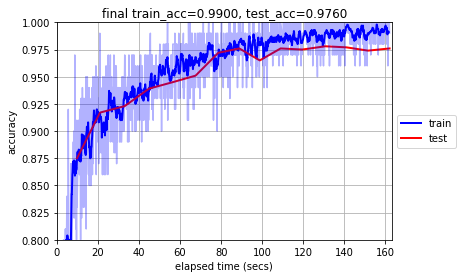

In [16]:
log_train, log_test, model_name = fit(X, Y, X_info,
                                      train_imgs, train_ohlabs, train_info,
                                      test_imgs, test_ohlabs, test_info,
                                      "extended_cnn_mnist", loss, train_step, accuracy,
                                      batch_size=100, n_epochs=15, log_freq=100)

plot_results(log_train, log_test)
print "free mem", humanbytes(psutil.virtual_memory().free)